In [1]:
import seaborn as sns
import pandas as pd
import mdtraj as md
import os
from numba import jit
import numpy as np
import scipy.signal
import re

#Matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches




In [6]:
COMPARE_NAMD_GMX = False

if COMPARE_NAMD_GMX:
    systems = ["apoe1","apoe3"]
    outputfolder = "comparative_analysis_GMX_NAMD"
    palette=["#0900ff","#ff0000","#8e8aff","#ffa6a6"]
else:
    # systems = ["apoe1","apoe2","apoe3","apoe4", "nmr"]
    systems = ["apoe1","apoe2","apoe3","apoe4"]
    outputfolder = "comparative_analysis"
    palette=None



replica = 1
COMPARE_REPLICA = False
APOE=1 
workdir = "D:/work/ApoE/simulation/apoe"
# workdir = "/Users/thibault/Documents/WORK/simu/apoe/"
if COMPARE_REPLICA:
    outputPNGdir = f"{workdir}/{outputfolder}/apoe{APOE}/PNG"
    outputCSVdir = f"{workdir}/{outputfolder}/apoe{APOE}/CSV"
else:
    outputPNGdir = f"{workdir}/{outputfolder}/replica{replica}/PNG"
    outputCSVdir = f"{workdir}/{outputfolder}/replica{replica}/CSV"
if not os.path.exists(outputPNGdir):
    os.makedirs(outputPNGdir)
if not os.path.exists(outputCSVdir):
    os.makedirs(outputCSVdir)

os.chdir(workdir)

In [7]:
def save_fig(figname,outputdir,format="png",dpi=300,bbox_inches='tight', transparent=False, facecolor="white"):
    from pathlib import Path
    Path(f"{outputdir}").mkdir(parents=True, exist_ok=True)

    plt.savefig(f"{outputdir}/{figname}.{format}", dpi=dpi, bbox_inches=bbox_inches, transparent=transparent, facecolor=facecolor)

In [12]:

def compare_analysis(analysisname, xaxis, yaxis, xlabel=None, ylabel=None, linewidth=1, vlines=[], add_namd=True, palette=None, ylim=None, replica=replica):
    dataframelist = []
    fig = plt.figure(figsize=(10,5))

    if analysisname[-4:] != ".csv":
        analysisname += ".csv"

    if COMPARE_REPLICA:
        replicas = [1,2,3]
        for replica in replicas:
            file = f"{workdir}/apoe{APOE}/results/replica_{replica}/prod/analysis/CSV/{analysisname}"
            df = pd.read_csv(file, sep=";")
            df["system"]=f"replica_{replica}"
            if add_namd:
                df = df[::2]
            dataframelist.append(df)
            title = f"Comparative analysis - {analysisname[:-4]} - APOE{APOE}"

    else:
        for system in systems:
            file = f"{workdir}/{system}/results/replica_{replica}/prod/analysis/CSV/{analysisname}"
            df = pd.read_csv(file, sep=";")
            df["system"]=system
            if add_namd:
                df = df[::2]
            dataframelist.append(df)
            title = f"Comparative analysis - {analysisname[:-4]}"


    if add_namd:
        namds=['apoe1','apoe3']
        for system in namds:
            file = f"{workdir}/namd-reza/{system}/analysis/CSV/{analysisname}"
            df = pd.read_csv(file, sep=";")
            df["system"]=f"{system}-namd"
            dataframelist.append(df)
        


    df_allsystems = pd.concat(dataframelist)
    df_allsystems = df_allsystems.reset_index(drop=True)

    if palette:
        graph = sns.lineplot(x=xaxis,y=yaxis,hue="system",data=df_allsystems, linewidth=linewidth, palette=palette)
    else:
        graph = sns.lineplot(x=xaxis,y=yaxis,hue="system",data=df_allsystems, linewidth=linewidth)
    if ylabel==None:
        ylabel = yaxis
    if xaxis == None:
        xlabel = xaxis

    for x in vlines:
        plt.axvline(x=x, color='grey', linewidth=1, linestyle="dotted")

    graph.set(ylabel=ylabel, 
              xlabel=xlabel,
              title=title,
              )

    if ylim and type(ylim) in [list, tuple]:
        graph.set(ylim=ylim)
    save_fig(analysisname[:-4], outputPNGdir)
    df_allsystems.to_csv(f"{outputCSVdir}/{analysisname}",sep=";", index=False)



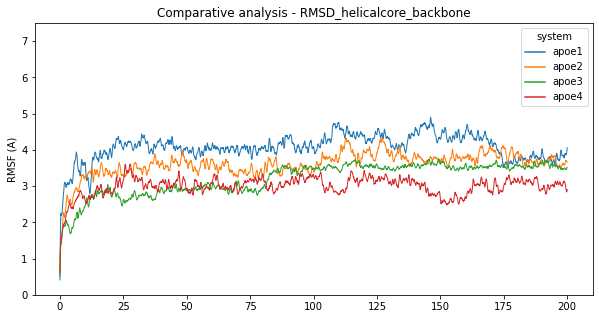

In [13]:
if COMPARE_REPLICA:
    ylim=None
else:
    ylim=(0,7.5)
# compare_analysis("RMSD_backbone", xaxis="Time (ns)",yaxis="Average", ylabel="RMSD (A)", palette=palette, add_namd=COMPARE_NAMD_GMX)
# compare_analysis("RMSD_backbone_initialState", xaxis="Time (ns)",yaxis="Average", ylabel="RMSD (A)", palette=palette, add_namd=COMPARE_NAMD_GMX)
# compare_analysis("RMSD_backbone_helicalCOre_initialState", xaxis="Time (ns)",yaxis="Average", ylabel="RMSD (A)", palette=palette, add_namd=COMPARE_NAMD_GMX)
# compare_analysis("RMSD_backbone_Nter_initialState", xaxis="Time (ns)",yaxis="Average", ylabel="RMSD (A)", palette=palette, add_namd=COMPARE_NAMD_GMX)

# compare_analysis("RMSF_backbone", xaxis="Residue",yaxis="RMSF (A)", ylabel="RMSF (A)", vlines=[112,158],palette=palette, add_namd=COMPARE_NAMD_GMX)
# compare_analysis("RMSF_protein", xaxis="Residue",yaxis="RMSF (A)", ylabel="RMSF (A)", vlines=[112,158],palette=palette, add_namd=COMPARE_NAMD_GMX)
# compare_analysis("RMSD_protein_nter", xaxis="Time (ns)",yaxis="Average", ylabel="RMSD (A)",palette=palette, add_namd=COMPARE_NAMD_GMX, ylim=ylim)
# compare_analysis("RMSF_protein_aligned-nter", xaxis="Residue",yaxis="RMSF (A)", ylabel="RMSD (A)", vlines=[112,158], palette=palette, add_namd=COMPARE_NAMD_GMX)


compare_analysis("RMSD_helicalcore_backbone", xaxis="Time (ns)",yaxis="Average", ylabel="RMSF (A)", palette=palette, add_namd=COMPARE_NAMD_GMX, ylim=(0,7.5), replica=replica)
# compare_analysis("165_backbone", xaxis="Time (ns)",yaxis="Average", ylabel="RMSF (A)",palette=palette, add_namd=COMPARE_NAMD_GMX, ylim=ylim)






# Compare distance matrices

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mdtraj as md
import argparse

import os
from numba import jit, njit, prange
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import gridspec
from scipy.stats import entropy, differential_entropy

def calc_rms_opti(vector):
    return np.sqrt(np.sum((vector-vector.mean())**2)/len(vector))

baseFolder="D:/work/ApoE/simulation/apoe"

apoe=[1,2,3,4]
replicas = [1,2,3]

matrices=[]

for system in apoe:
        for replica in replicas:
            matrices.append(np.load(f"{baseFolder}/apoe{system}/results/replica_{replica}/prod/analysis/PNG/distances/averageDist_apoe{system}_r{replica}.npy"))

matrices = np.array(matrices)

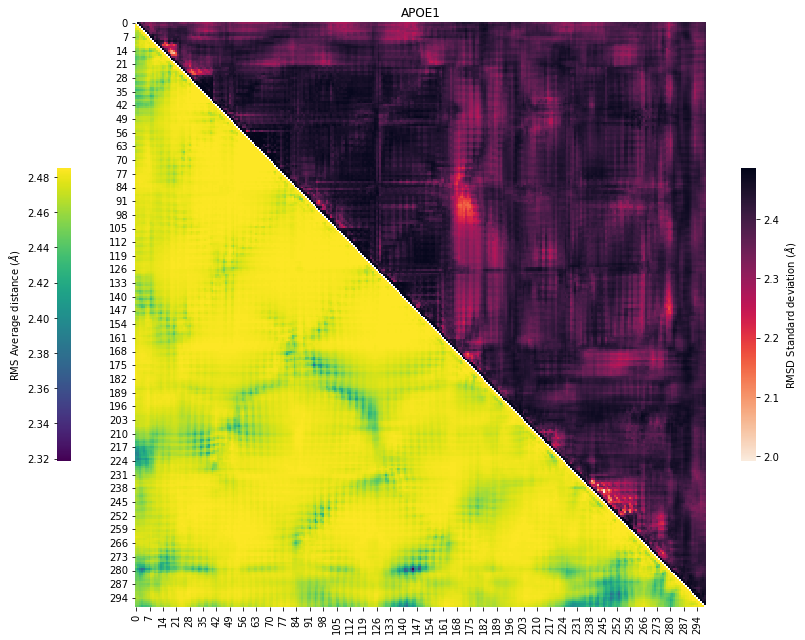

In [13]:
def calc_matrix_rmsd(matrix):
    matrixSize = matrix.shape[1]
    rms_matrix = np.zeros((matrixSize,matrixSize), dtype=np.float32)
    for i in range(matrixSize):
        for j in range(matrixSize):
            if j != i:
                rms_matrix[i,j] = calc_rms_opti(matrix[:,i,j])

    return rms_matrix

def calc_matrix_shannon(matrix):
    matrixSize = matrix.shape[1]
    shannon_matrix = np.zeros((matrixSize,matrixSize), dtype=np.float32)
    for i in range(matrixSize):
        for j in range(matrixSize):
            if j != i:
                shannon_matrix[i,j] = entropy(matrix[:,i,j])

    return shannon_matrix


def test(vector):
    entropy = -sum(vector *np.log(vector))
    return entropy



def plot_matrix(matrix, title="RMS Matrix"):
    # fig, ax = plt.subplots(figsize=(10,8))

    fig, ax0 = plt.subplots(figsize=(13,9))
    average = matrix.copy()
    average *= np.tri(*matrix.shape) # Set the upper triangle to 0
    average [average == 0] = np.nan

    std = matrix.copy()
    std *= 1 - np.tri(*std.shape, k=-1) # Set the lower triangle to 0
    std [std == 0] = np.nan

    g = sns.heatmap(average, cmap="viridis", ax=ax0,cbar_kws = {"shrink":0.5,'location':"left",'pad':0.07,  'label': r'RMS Average distance ($\AA$)'})
    g = sns.heatmap(std, cmap="rocket_r", ax=ax0, cbar_kws = {"shrink":0.5, 'location':"right",'label': r'RMSD Standard deviation ($\AA$)'}, )
    g.set(title=title)


    plt.tight_layout()
    
    # plt.close()

plot_matrix(calc_matrix_shannon(matrices), title="APOE1")


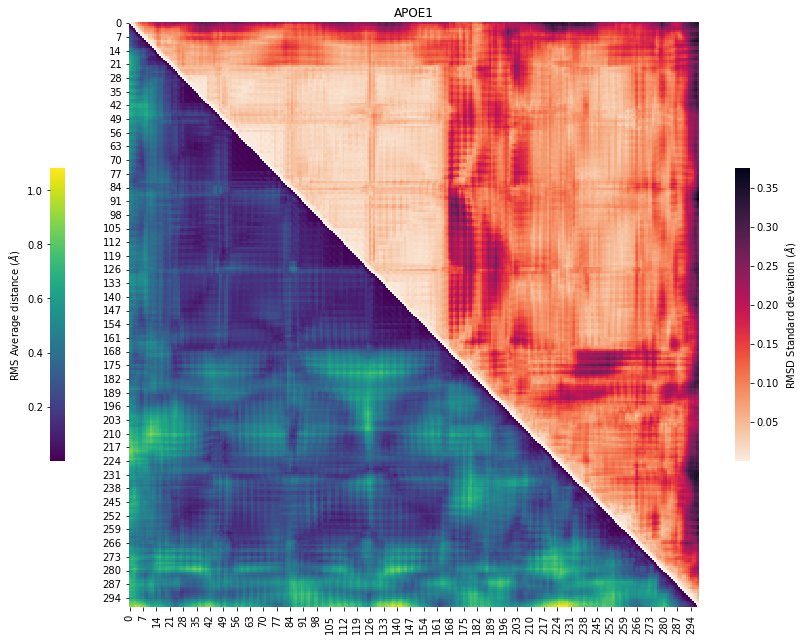

In [16]:
plot_matrix(calc_matrix_rmsd(matrices), title="APOE1")


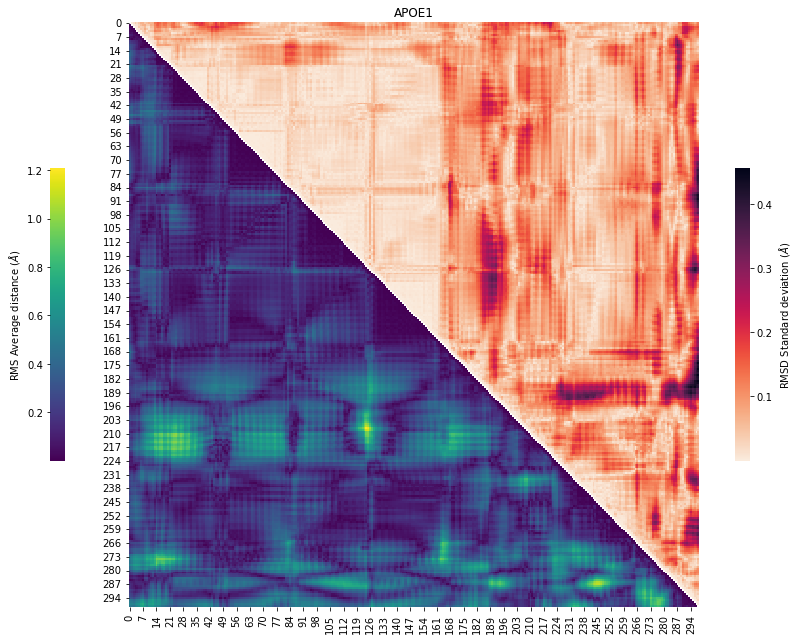

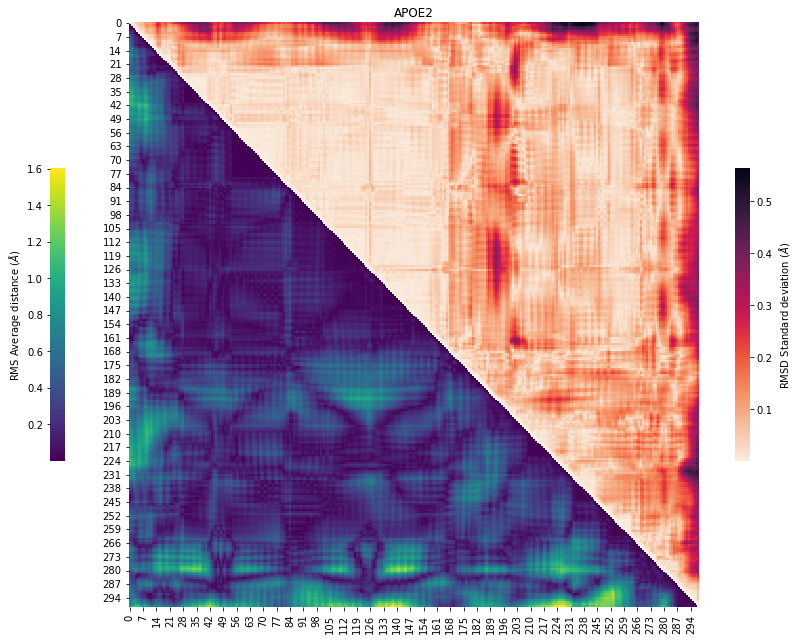

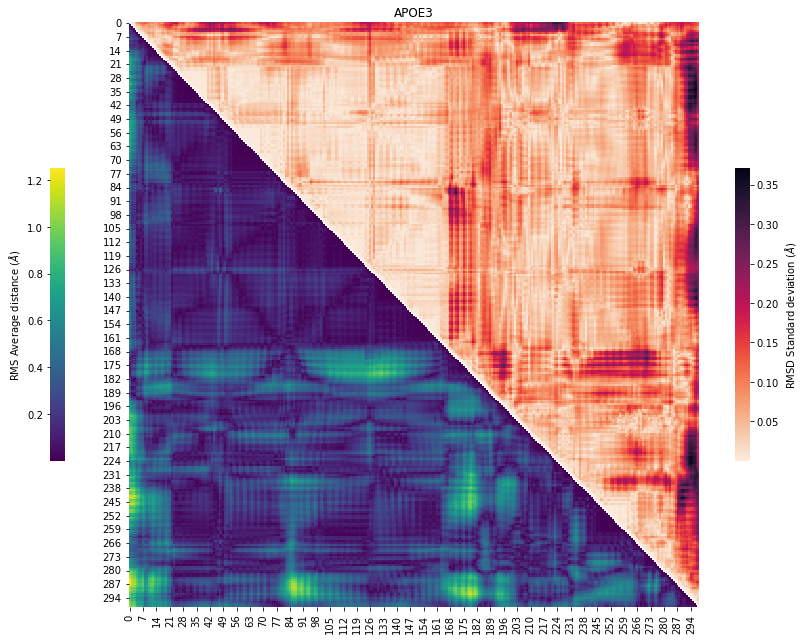

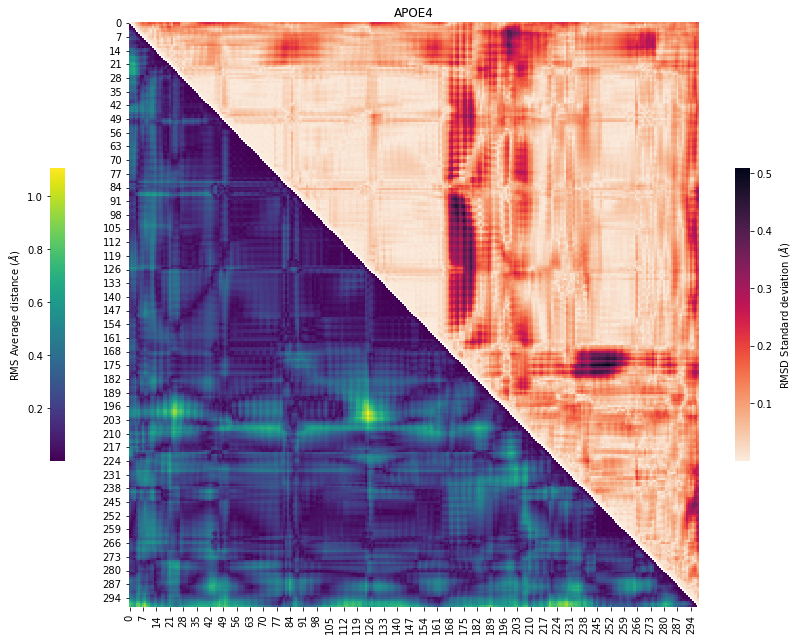

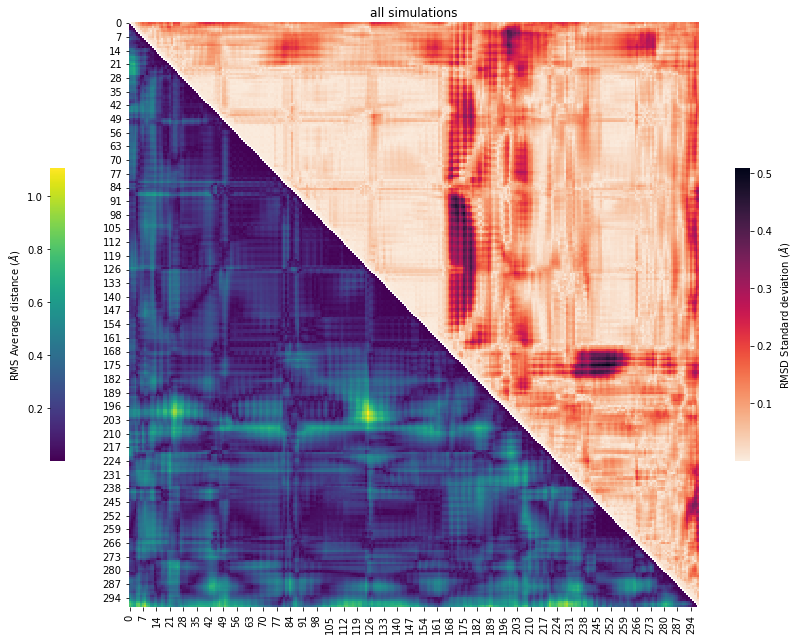

In [53]:
plot_matrix(calc_matrix_rmsd(matrices[0:3,:,:]), title="APOE1")
plot_matrix(calc_matrix_rmsd(matrices[3:6,:,:]), title="APOE2")
plot_matrix(calc_matrix_rmsd(matrices[6:9,:,:]), title="APOE3")
plot_matrix(calc_matrix_rmsd(matrices[9:12,:,:]), title="APOE4")
plot_matrix(calc_matrix_rmsd(matrices[9:12,:,:]), title="all simulations")